In [1]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import functools

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

In [8]:
import UNETLibrary
from ImageGen import *
from UNETLibrary import *

## Prepare the image files for readable format

In [2]:
# creating (0,1) masks 
tile_x, tile_y, count= tile_id_gen()
print("Generating {} masks .....".format(count))
for i in range(count):
    mask_sequence = get_mask_pixels(tile_x[i], tile_y[i],mask_type='sugarcane')
print("all {} masks are saved".format(count))

Creating the Data list .....
65 tiles ids are created
Generating 65 masks .....
all 65 masks are saved


In [3]:
# getting filenames
f = open("./ModelTrainingData/TileIds.txt")
x_train_filenames = []
y_train_filenames = []
DATE = '2019-08-09'
# each mask has 3 inputs, namely tci, ndvi and fci
for id in f:
    id = str(id).replace("\n","")
    x_train_filenames.append(os.path.join('./ModelTrainingData/input', 
                                          "tci-{}-{}.png".format(id,DATE)))
    y_train_filenames.append(os.path.join('./ModelTrainingData/label', 
                                          "mask-{}.png".format(id)))
    x_train_filenames.append(os.path.join('./ModelTrainingData/input', 
                                          "ndvi-{}-{}.png".format(id,DATE)))
    y_train_filenames.append(os.path.join('./ModelTrainingData/label', 
                                          "mask-{}.png".format(id)))
    x_train_filenames.append(os.path.join('./ModelTrainingData/input', 
                                          "fci-mode1-{}-{}.png".format(id,DATE)))
    y_train_filenames.append(os.path.join('./ModelTrainingData/label', 
                                          "mask-{}.png".format(id)))

# splitting into train/val set 
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, 
                                     test_size=0.2, random_state=42)

print("There are {} training inputs.".format(len(x_train_filenames)))
print("There are {} validation labels.".format(len(y_val_filenames)))
print(x_train_filenames[:4])
print(y_train_filenames[:4])    

There are 156 training inputs.
There are 39 validation labels.
['./ModelTrainingData/input/fci-mode1-1536-1536-2019-08-09.png', './ModelTrainingData/input/tci-6656-7168-2019-08-09.png', './ModelTrainingData/input/fci-mode1-6656-4608-2019-08-09.png', './ModelTrainingData/input/fci-mode1-7168-5632-2019-08-09.png']
['./ModelTrainingData/label/mask-1536-1536.png', './ModelTrainingData/label/mask-6656-7168.png', './ModelTrainingData/label/mask-6656-4608.png', './ModelTrainingData/label/mask-7168-5632.png']


## Set up image augmentation


In [35]:
img_shape = (512, 512, 3)
batch_size = 3
epochs = 1

In [32]:
# apply image augmentation to training set but not validation set 
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0,
    'height_shift_range': 0
} # passing augment parameters
tr_preprocessing_fn = functools.partial(UNETLibrary._augment, **tr_cfg)  



val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(UNETLibrary._augment, **val_cfg)


train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

(512, 512, 3) 0.0


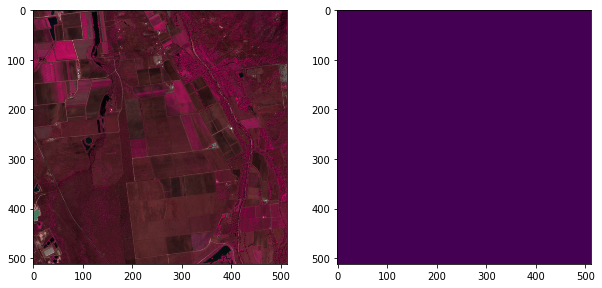

In [49]:
# let's see does the augmentation work
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
    batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = batch_of_imgs[0]
    print(img.shape, np.sum(label[0,:,:,0]))

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(label[0, :, :, 0])
    plt.show()

[82  6  8] [0]
(512, 512, 3) (511, 511, 1) 0


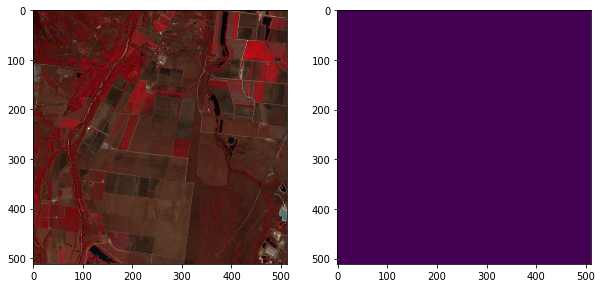

In [53]:
# reading one file and see  
fname=x_train_filenames[0]
label_path = y_train_filenames[0]

img_str = tf.read_file(fname)
img = tf.image.decode_png(img_str, channels=3)
   
label_str=tf.read_file(label_path)
label=tf.image.decode_png(label_str)

with tf.Session() as sess:
    img = sess.run(img)
    label = sess.run(label)
    
    print(img[0,0],label[0,0])
    print(img.shape, label.shape, np.sum(label))

    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(label[:,:,0])
    plt.show()


[82  6  8] [0]
(512, 512, 3) (511, 511, 1)
